In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import ast

In [2]:
# do verbose sanity checks, and do not save in the end
test = False
save_paired = False
save_merged = False
save_merged_agg_session = False
save_merged_agg_port = True

# Loading data into pandas dataframe
path = "../../data/clean/"

if save_paired:
    file_sessions = "sessions_clean.csv"
    file_intervals = "intervals_clean.csv"
else:
    file_sessions = "sessions_paired.csv"
    file_intervals = "intervals_paired.csv"    
    
if test:
    nrows = 1e7
else:
    nrows = None
    
def get_csv(file):
    print("Reading {} rows of {}".format(nrows if nrows is not None else "ALL", file))
    return pd.read_csv(path + file, index_col=False, nrows=nrows)

In [3]:
session = get_csv(file_sessions)
interval = get_csv(file_intervals)

Reading ALL rows of sessions_paired.csv
Reading ALL rows of intervals_paired.csv


In [4]:
# sessions_raw = get_csv(file_sessions)
# intervals_raw = get_csv(file_intervals)
# session = sessions_raw.copy(deep=True)
# interval = intervals_raw.copy(deep=True)

In [6]:
print(list(interval))
print(list(session))

['Interval ID', 'Session ID', 'Interval Start Time (Local)', 'Interval Duration (Secs)', 'Interval Energy', 'Peak Power', 'Average Power']
['Session ID', 'Station ID', 'Port ID', 'Connector Type', 'POI Category', 'POI Subcategory', 'Session Time Zone', 'Session Time (secs)', 'Charging Time (secs)', 'Start SoC', 'End SoC', 'Full Charge', 'Energy (kWh)', 'Driver ID', 'Driver Zip', 'Vehicle Make', 'Vehicle Model', 'Battery Capacity', 'EV Type', '$ Fee', 'Fee Currency', 'Zip Code', 'City', 'County', 'State', 'Country', 'Driver City', 'Driver State', 'Driver Country', 'Max Power', 'Session Type', 'Vehicle Model Year', 'start_datetime', 'start_seconds', 'start_year', 'start_month', 'start_day', 'start_weekday']


# Helper Fun

In [9]:
def apply_inplace(df, field, fun):
    return pd.concat([df.drop(field, axis=1), df[field].apply(fun)], axis=1) 

In [10]:
def str_list(x):
    return str(list(x))

# Remove Sessions and Intervals without a pair

In [11]:
def remove_unpaired(session, interval):
    # Getting unique session ID values from interval data
    interval_session_IDs_unique = interval['Session ID'].unique()
    session_IDs_unique = session['Session ID'].unique()
    interval_set = set(interval_session_IDs_unique)
    session_set = set(session_IDs_unique)
    paired = interval_set.intersection(session_set)
    print("Number of unique sessions ID in interval data: ", len(interval_session_IDs_unique))
    print("Number of unique sessions ID in session data: ", len(session_IDs_unique))
    print("Number of unique sessions ID in both: ", len(paired))

    # Getting boolean array to check whether session ID from interval data is in session data
    session_has_pair = session['Session ID'].isin(paired)
    # Removing session IDs that are not part of interval data
    session_with_pair = session[session_has_pair]
    
    # Getting boolean array removing interval data that got removed from session data cleaning
    interval_has_pair = interval['Session ID'].isin(paired)
    # Getting final interval data
    interval_with_pair = interval[interval_has_pair]
    
    print("Change of unique sessions ID in session data: ", 
          len(session_with_pair['Session ID'].unique()) - session_IDs_unique)
    print("change of unique sessions ID in interval data: ", 
          len(interval_with_pair['Session ID'].unique()) - interval_session_IDs_unique)
    return session_with_pair, interval_with_pair


In [12]:
if save_paired:
    session, interval = remove_unpaired(session, interval)

In [13]:
if save_paired:
    print("resave paired sessions")
    session.to_csv(path +'sessions_paired.csv',sep=',', index=False)
    print("resave paired intervals")
    interval.to_csv(path +'intervals_paired.csv', index=False)

# Merge and save without aggregating

In [14]:
merged = pd.merge(left=session, right=interval, on='Session ID')

In [ ]:
if save_merged:
    print("save merged")
    merged.to_csv(path +'merged.csv',sep=',', index=False)
    print("done")

# Experiments

In [8]:
# interval['start_datetime'] = interval['start_datetime'].apply(
#     lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [9]:
# naming collisions
# list(set(list(interval)).intersection(list(session)))

In [10]:
# interval.rename(columns={'start_datetime': 'interval_datetime'}, inplace=True)

In [11]:
# interval = interval.drop(columns=['start_time_seconds'])

In [12]:
# list(set(list(interval)).intersection(list(session)))

In [13]:
# Merge

In [14]:
# data = pd.merge(left=session, right=interval, on='Session ID')

In [15]:
# session.head(5)

In [16]:
# interval.head(5)

In [17]:
# data.head(5)
# is not really tidy.

# idea: group intervals by session id, make all variables lists, then merge


In [16]:
# df = interval.copy(deep=True)
# # df = df.sort_values(['interval_datetime']) # logical choice, but timestamps are not always correct.
# df = df.sort_values(['Interval ID']) # seems to work aswell. Has same amount of errors
# df = df.groupby('Session ID', as_index=False)

In [17]:
# df.head(5)

In [18]:
# df2 = df.agg(list)

In [19]:
# df.head(5)

In [20]:
# df['num_intervals'] = df["Interval ID"].apply(len)

# D-tour: Are interval durations and date-time stamps consistent? 
Answer: not always.

In [18]:
# df2["duration_1"] = df2.apply(lambda x: sum(x["Interval Duration (Secs)"][:-1]), axis=1)

In [19]:
# df2.head(5)

In [20]:
# df2["diff_1"] = df2.apply(lambda x: 
#                           (x["start_datetime"][-1] - x["start_datetime"][0]).total_seconds(), 
#                           axis=1)

In [21]:
# df_error = df2[df2["diff_1"] != df2["duration_1"]]

In [22]:
# print(len(df2))
# print(len(df_error))

In [23]:
# df2["diff"] = df2["diff_1"] - df2["duration_1"]

In [24]:
# df2.sort_values("diff", ascending=False).head(5)

In [25]:
# for x in df2.sort_values("diff", ascending=False).head(5).iloc[1]:
#     print(x)

# Aggregate before merging


### To reduce footprint, round to 4 decimal places

In [7]:
decimals = {
    'Interval Energy': 4, 
    'Peak Power': 4, 
    'Average Power': 4,
}
interval = interval.round(decimals=decimals)

In [8]:
interval.head(10)

,Interval ID,Session ID,Interval Start Time (Local),Interval Duration (Secs),Interval Energy,Peak Power,Average Power
0,751891049,26149711,2015-05-03 22:15:53.0,847,1.2996,5.7168,5.5236
1,751891051,26149711,2015-05-03 22:30:00.0,900,1.4297,5.7303,5.7188
2,751891053,26149711,2015-05-03 22:45:00.0,900,1.4340,5.7517,5.7358
3,751891055,26149711,2015-05-03 23:00:00.0,900,1.4308,5.7322,5.7231
4,751891057,26149711,2015-05-03 23:15:00.0,900,1.4325,5.7328,5.7300
5,751891059,26149711,2015-05-03 23:30:00.0,900,1.4174,5.7338,5.6697
6,751891061,26149711,2015-05-03 23:45:00.0,900,0.9115,5.0972,3.6460
7,751891063,26149711,2015-05-04 00:00:00.0,900,0.4643,2.5260,1.8571
8,751891065,26149711,2015-05-04 00:15:00.0,900,0.1889,1.3999,0.7555
9,751912503,26167547,2015-05-04 09:28:20.0,100,0.1044,5.0150,3.7584


## Agg by session

In [20]:
if save_merged_agg_session:
    df = interval.copy(deep=True)
    # df = df.sort_values(['interval_datetime']) # logical choice, but timestamps are not always correct.
    df = df.sort_values(['Interval ID']) # seems to work aswell. Has same amount of errors
    df = df.drop(columns=['Interval ID'])
    df = df.groupby('Session ID', as_index=False)

In [24]:
if save_merged_agg_session:
    print("aggregating")
    df = df.agg(str_list)


aggregating


In [25]:
if save_merged_agg_session:
    print("merging")
    data = pd.merge(left=session, right=df, on='Session ID')

In [31]:
if save_merged_agg_session: 
    print("save paired sessions, aggregated by session")
    data.to_csv(path +'merged_agg_session.csv',sep=',', index=False)

save paired sessions, aggregated by session


In [26]:
print(list(data))
data.head(5)

['Session ID', 'Station ID', 'Port ID', 'Connector Type', 'POI Category', 'POI Subcategory', 'Session Time Zone', 'Session Time (secs)', 'Charging Time (secs)', 'Start SoC', 'End SoC', 'Full Charge', 'Energy (kWh)', 'Driver ID', 'Driver Zip', 'Vehicle Make', 'Vehicle Model', 'Battery Capacity', 'EV Type', '$ Fee', 'Fee Currency', 'Zip Code', 'City', 'County', 'State', 'Country', 'Driver City', 'Driver State', 'Driver Country', 'Max Power', 'Session Type', 'Vehicle Model Year', 'start_datetime', 'start_seconds', 'start_year', 'start_month', 'start_day', 'start_weekday', 'Interval Start Time (Local)', 'Interval Duration (Secs)', 'Interval Energy', 'Peak Power', 'Average Power']


,Session ID,Station ID,Port ID,Connector Type,POI Category,POI Subcategory,Session Time Zone,Session Time (secs),Charging Time (secs),Start SoC,...,start_seconds,start_year,start_month,start_day,start_weekday,Interval Start Time (Local),Interval Duration (Secs),Interval Energy,Peak Power,Average Power
0,99999951,155805,208243.0,J1772,Parking,Commercial,PDT,4143,4130,NaN,...,49812,2017,9,264,3,"['2017-09-21 13:50:12.0', '2017-09-21 14:00:00...","[588, 900, 900, 900, 852]","[0.9428, 1.4959, 1.4785, 1.4985, 1.4078]","[5.992, 5.9624, 5.9617, 6.0112, 6.0064]","[5.7725, 5.9837, 5.9139, 5.9938, 5.9483]"
1,99999911,127071,166451.0,J1772,Workplace,High-Tech,PDT,14104,10440,NaN,...,47701,2017,9,264,3,"['2017-09-21 13:15:00.0', '2017-09-21 13:30:00...","[900, 900, 900, 900, 900, 900, 900, 900, 900, ...","[0.7774, 0.8061, 0.8068, 0.8073, 0.8062, 0.804...","[3.2187, 3.2279, 3.2346, 3.235, 3.2294, 3.2259...","[3.1097, 3.2244, 3.2271, 3.229, 3.2249, 3.2198..."
2,99999881,143745,191547.0,J1772,Workplace,General,PDT,4364,1328,NaN,...,49813,2017,9,264,3,"['2017-09-21 13:50:13.0', '2017-09-21 14:00:00...","[587, 900]","[0.4999, 0.4977]","[3.191, 3.194]","[3.0656, 1.9909]"
3,99999861,78433,195605.0,J1772,Workplace,General,PDT,9818,9811,NaN,...,49811,2017,9,264,3,"['2017-09-21 13:50:11.0', '2017-09-21 14:00:00...","[589, 900, 900, 900, 900, 900, 900, 900, 900, ...","[0.9106, 1.4252, 1.4273, 1.4312, 1.43, 1.4299,...","[5.7417, 5.7135, 5.7185, 5.7277, 5.7287, 5.729...","[5.5655, 5.7006, 5.709, 5.7248, 5.7199, 5.7196..."
4,99999851,93629,105187.0,J1772,Workplace,General,PDT,7165,6849,NaN,...,49814,2017,9,264,3,"['2017-09-21 13:50:14.0', '2017-09-21 14:00:00...","[586, 900, 900, 900, 900, 900, 900, 900]","[0.3542, 0.3996, 0.2998, 0.2933, 0.2945, 0.325...","[2.2728, 2.2695, 1.2451, 1.1886, 1.1939, 2.270...","[2.1762, 1.5982, 1.199, 1.173, 1.178, 1.3, 2.2..."


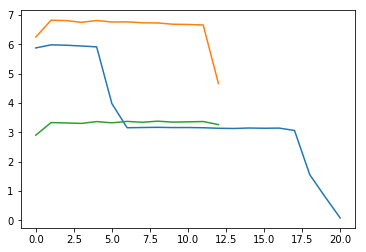

In [29]:
avg = data["Average Power"]
for i in np.random.randint(len(avg), size=3):
#     print(avg[i])
    plt.plot(ast.literal_eval(avg[i]))

Session ID                                                           73293485
Station ID                                                             112405
Port ID                                                                138793
Connector Type                                                          J1772
POI Category                                                        Workplace
POI Subcategory                                                       General
Session Time Zone                                                         PDT
Session Time (secs)                                                     18944
Charging Time (secs)                                                    14984
Start SoC                                                                 NaN
End SoC                                                                   NaN
Full Charge                                                              True
Energy (kWh)                                                    

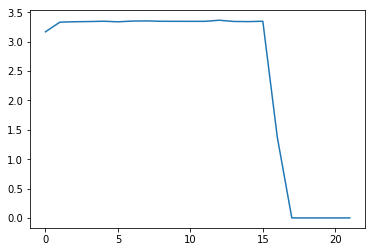

In [38]:
for i in np.random.randint(len(data), size=1):
    print(data.iloc[i])
    plt.plot(ast.literal_eval(data.iloc[i]["Average Power"]))

In [205]:
# total = data['Energy (kWh)']
data["norm"] = data.apply(
    lambda x: [(a)/(sum(x["Average Power"])+1e-10) 
               for a in x["Average Power"].apply(ast.literal_eval)],
    axis=1
)

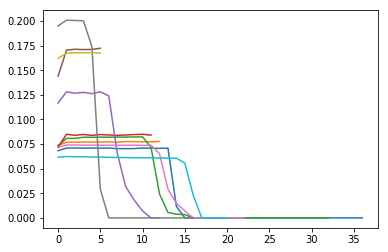

In [225]:
avg = data["norm"]
for i in np.random.randint(len(avg), size=10):
#     print(avg[i])
    plt.plot(ast.literal_eval(avg[i]))